In [79]:
# Generic
import typing
import os
from pathlib import Path

# Plotting
import matplotlib.pyplot as plt

# Numerical Computing
import numpy as np
import torch

# Utilities
from muutils.statcounter import StatCounter

# Our Code
from maze_transformer.utils.notebook_utils import configure_notebook
from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.evaluation.eval_model import MazePath, ArrMazePath, load_model_with_configs, predict_maze_path, predict_maze_paths
from maze_transformer.evaluation.pathdist import MazeEvalFunction, ArrMazeEvalFunction, MazeEvalFuncs, ArrMazeEvalFuncs

In [80]:
# Setup
device = configure_notebook(seed=42, dark_mode=True)
# We won't be training any models
torch.set_grad_enabled(False)

# Get latest model
# this should point towards a directory containing a run. 
# If you don't have any runs, you can create a dataset with `poetry run python scripts/create_dataset.py create ./data/maze 10 --grid_n=4`
# Then train a model with poetry run python scripts/train_model.py ./data/maze/g4-n10`
run_path = Path("../data/maze/g4-n10")
assert run_path.exists(), f"Run path {run_path.as_posix()} does not exist"
model_path = list(sorted(run_path.glob("**/model.final.pt"), key=os.path.getmtime))[
	-1
].resolve()
maze_path = run_path / "maze_tokens.jsonl"

# plot example mazes

pre-gen: 0:00:00.000090
gen: 0:00:00.050134
post-gen: 0:00:00.000814
pre-gen: 0:00:00.000179
gen: 0:00:00.049678
post-gen: 0:00:00.000607
pre-gen: 0:00:00.000079
gen: 0:00:00.045462
post-gen: 0:00:00.000465
pre-gen: 0:00:00.000047
gen: 0:00:00.050596
post-gen: 0:00:00.000425
pre-gen: 0:00:00.000050
gen: 0:00:00.064921
post-gen: 0:00:00.000659
pre-gen: 0:00:00.000064
gen: 0:00:00.048256
post-gen: 0:00:00.000612
pre-gen: 0:00:00.000064
gen: 0:00:00.057330
post-gen: 0:00:00.000439
pre-gen: 0:00:00.000049
gen: 0:00:00.053277
post-gen: 0:00:00.000426
pre-gen: 0:00:00.000047
gen: 0:00:00.047218
post-gen: 0:00:00.000530
pre-gen: 0:00:00.000052
gen: 0:00:00.031756
post-gen: 0:00:00.000512


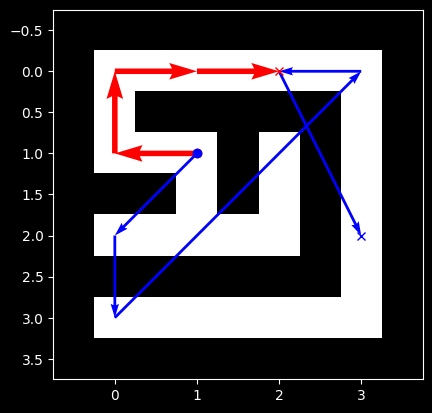

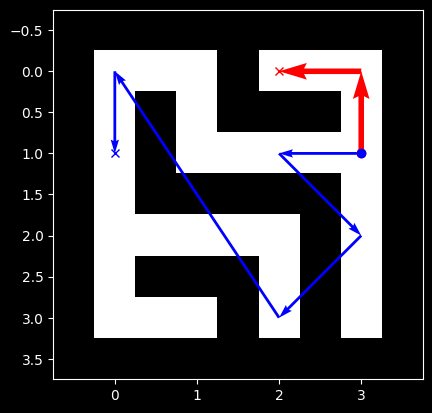

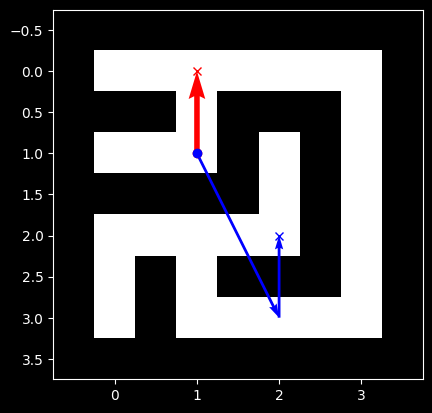

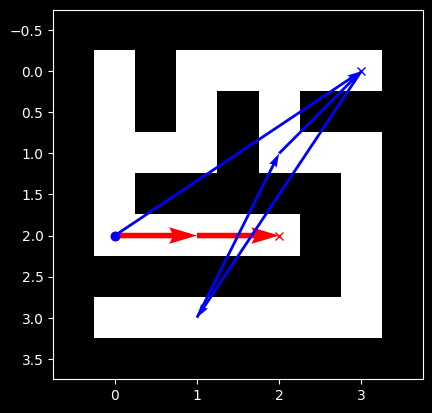

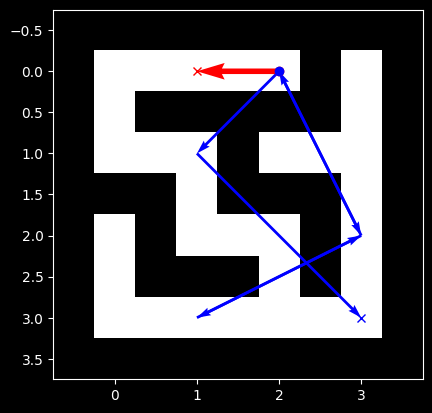

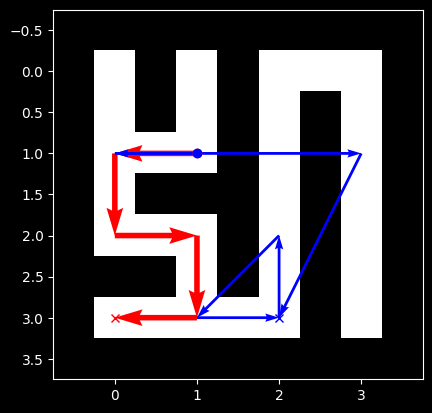

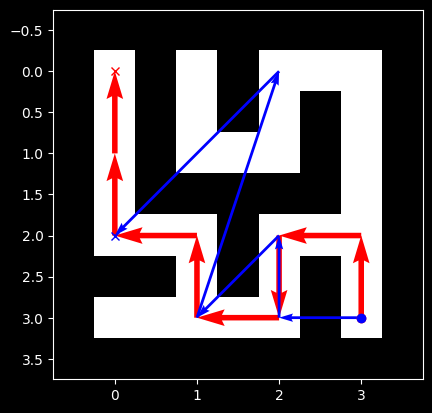

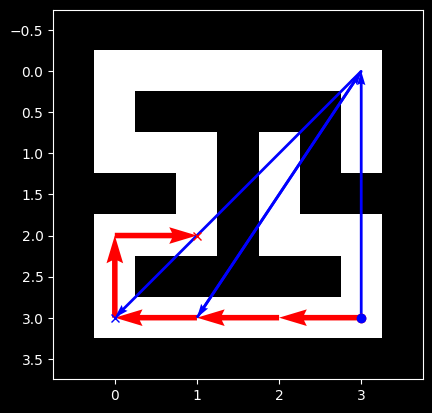

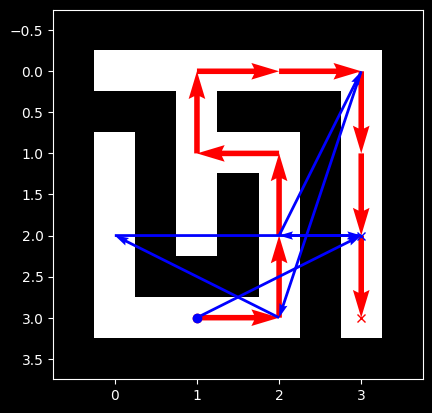

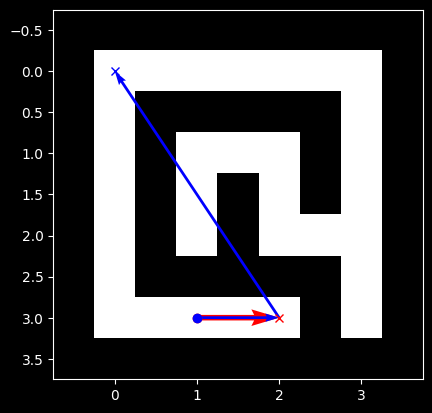

In [81]:
# setup consts
def testdata_plot_predicted_path(
		model_path: Path,
		maze_tokens_path: Path, 
		n_mazes: int = 10,
		n_tokens_pred: int = 8,
	):
	# load model and configs
	model, cfg = load_model_with_configs(model_path)
	
	# load maze test data
	mazes_tokens: list[list[str]] = [
 	   line.split() for line in maze_tokens_path.read_text().splitlines()
	]
	mazes_tokens = mazes_tokens[:n_mazes]

	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = [
		predict_maze_path(
			tokens = tokens,
			data_cfg = cfg.dataset_cfg,
			model = model,
		n_tokens_pred = n_tokens_pred,
		)
		for tokens in mazes_tokens
	]


	# plot
	for maze, path, path_pred in mazes_solved:
		plot_multi_paths(
			maze = maze,
			paths = [
				PathFormat(path, "true", color = "red", quiver_kwargs = {'width': 0.015}),
				PathFormat(path_pred, "predicted", color = "blue", quiver_kwargs = {}),
			],
		)

testdata_plot_predicted_path(model_path, maze_path)

# run path dist eval

In [82]:
EvalFuncTuple = tuple[typing.Literal["arr", "list"], MazeEvalFunction|ArrMazeEvalFunction]

ALL_PATHDIST_FUNCS: dict[str, EvalFuncTuple] = {
	**{
		name: ("arr", func)
		for name, func in ArrMazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
	**{
		name: ("list", func)
		for name, func in MazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
}

print(ALL_PATHDIST_FUNCS)

{'num_connections_adjacent_lattice': ('arr', <staticmethod(<function ArrMazeEvalFuncs.num_connections_adjacent_lattice at 0x121ce7d90>)>), 'fraction_connections_adjacent_lattice': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent_lattice at 0x121ce7e20>)>), 'num_connections_adjacent': ('arr', <staticmethod(<function ArrMazeEvalFuncs.num_connections_adjacent at 0x121ce7eb0>)>), 'fraction_connections_adjacent': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent at 0x121ce7f40>)>), 'node_overlap': ('list', <staticmethod(<function MazeEvalFuncs.node_overlap at 0x121ce7d00>)>)}


In [83]:
def evaluate_model_pathdist_scores(
		model_path: Path,
		maze_tokens_path: Path,
		pathdist_functions: dict[str, EvalFuncTuple] | None = ALL_PATHDIST_FUNCS,
		n_tokens_pred: int = 8,
		n_mazes: int = 64,
		verbose: bool = False,
	) -> dict[str, StatCounter]:

	mazes_tokens: list[list[str]] = list()

	# load model and configs
	model, cfg = load_model_with_configs(model_path)

	# load maze test data
	mazes_tokens: list[list[str]] = [
 	   line.split() for line in maze_tokens_path.read_text().splitlines()
	]

	mazes_tokens_initial = mazes_tokens
	mazes_tokens_after = []
	with open(maze_tokens_path, "r") as f:
		for idx, line in enumerate(f):
			mazes_tokens_after.append(line.split())
			if idx >= n_mazes:
				break
	assert all([x==y for x,y in zip(mazes_tokens_initial, mazes_tokens_after)])
	print('passed check')

	# predict paths
	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = list()
	for tokens in mazes_tokens:
		maze, p_true, p_pred = predict_maze_path(
			tokens = tokens,
			data_cfg = cfg.dataset_cfg,
			model = model,
			n_tokens_pred = n_tokens_pred,
			verbose = verbose,
		)

		mazes_solved.append((maze, p_true, p_pred))

		if verbose:
			print(f"{p_true = }")
			print(f"{p_pred = }")

	# convert paths
	mazes_solved_arrpath: list[tuple[LatticeMaze, ArrMazePath, ArrMazePath]] = [
		(maze, np.array(p_true), np.array(p_pred))
		for maze, p_true, p_pred in mazes_solved
	]

	# evaluate
	pathdist_scores: dict[str, StatCounter] = dict()
	for name, (pathdist_type, pathdist_func) in pathdist_functions.items():
		if pathdist_type == "list":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved
			)
		elif pathdist_type == "arr":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved_arrpath
			)
		else:
			raise ValueError(f"Invalid pathdist_type: {pathdist_type}")

	return pathdist_scores


In [84]:

def evaluate_model_pathdist_scores2(
		model_path: Path,
		maze_tokens_path: Path,
		pathdist_functions: dict[str, EvalFuncTuple] | None = ALL_PATHDIST_FUNCS,
		n_tokens_pred: int = 8,
		n_mazes: int = 64,
		verbose: bool = False,
	) -> dict[str, StatCounter]:

	mazes_tokens: list[list[str]] = list()
	print(mazes_tokens)
	# load model and configs
	model, cfg = load_model_with_configs(model_path)

	# load maze test data
	mazes_tokens: list[list[str]] = [
 	   line.split() for line in maze_tokens_path.read_text().splitlines()
	]
	print(mazes_tokens)

	mazes_tokens_initial = mazes_tokens
	mazes_tokens_after = []
	with open(maze_tokens_path, "r") as f:
		for idx, line in enumerate(f):
			mazes_tokens_after.append(line.split())
			if idx >= n_mazes:
				break
	assert all([x==y for x,y in zip(mazes_tokens_initial, mazes_tokens_after)])
	print('passed check')

	# predict paths
	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = list()
	# This is 99% of the runtime
	p_preds = predict_maze_paths(mazes=mazes_tokens, data_cfg = cfg.dataset_cfg,model = model, n_tokens_pred = n_tokens_pred)
	
	for tokens in mazes_tokens:
		maze, p_true, p_pred = predict_maze_path(
			tokens = tokens,
			data_cfg = cfg.dataset_cfg,
			model = model,
			n_tokens_pred = n_tokens_pred,
			verbose = verbose,
		)


		mazes_solved.append((maze, p_true, p_pred))

		if verbose:
			print(f"{p_true = }")
			print(f"{p_pred = }")

	# convert paths
	mazes_solved_arrpath: list[tuple[LatticeMaze, ArrMazePath, ArrMazePath]] = [
		(maze, np.array(p_true), np.array(p_pred))
		for maze, p_true, p_pred in mazes_solved
	]

	# evaluate
	pathdist_scores: dict[str, StatCounter] = dict()
	for name, (pathdist_type, pathdist_func) in pathdist_functions.items():
		if pathdist_type == "list":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved
			)
		elif pathdist_type == "arr":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved_arrpath
			)
		else:
			raise ValueError(f"Invalid pathdist_type: {pathdist_type}")

	return pathdist_scores


In [85]:
from datetime import datetime
one_start = datetime.now()
# one = evaluate_model_pathdist_scores(model_path, maze_path)
one_end = datetime.now()
two = evaluate_model_pathdist_scores2(model_path, maze_path)
two_end = datetime.now()
# print('one - ', one_end - one_start, ' - ', one)
print('two - ', two_end - one_end, ' - ', two)

[]
[['<ADJLIST_START>', '(2,1)', '<-->', '(1,1)', ';', '(1,0)', '<-->', '(1,1)', ';', '(1,0)', '<-->', '(0,0)', ';', '(0,1)', '<-->', '(0,0)', ';', '(0,1)', '<-->', '(0,2)', ';', '(1,3)', '<-->', '(0,3)', ';', '(3,2)', '<-->', '(3,3)', ';', '(2,2)', '<-->', '(1,2)', ';', '(1,3)', '<-->', '(2,3)', ';', '(2,1)', '<-->', '(2,2)', ';', '(3,3)', '<-->', '(2,3)', ';', '(2,0)', '<-->', '(2,1)', ';', '(0,2)', '<-->', '(0,3)', ';', '(3,1)', '<-->', '(3,2)', ';', '(3,0)', '<-->', '(3,1)', ';', '<ADJLIST_END>', '<ORIGIN_START>', '(1,1)', '<ORIGIN_END>', '<TARGET_START>', '(0,2)', '<TARGET_END>', '<PATH_START>', '(1,1)', '(1,0)', '(0,0)', '(0,1)', '(0,2)', '<PATH_END>'], ['<ADJLIST_START>', '(2,1)', '<-->', '(2,0)', ';', '(0,3)', '<-->', '(1,3)', ';', '(2,3)', '<-->', '(1,3)', ';', '(1,1)', '<-->', '(1,2)', ';', '(3,2)', '<-->', '(2,2)', ';', '(0,2)', '<-->', '(0,3)', ';', '(2,0)', '<-->', '(3,0)', ';', '(0,0)', '<-->', '(0,1)', ';', '(1,1)', '<-->', '(0,1)', ';', '(3,3)', '<-->', '(2,3)', ';', '(

  0%|          | 0/8 [00:00<?, ?it/s]

pre-gen: 0:00:00.000077
gen: 0:00:00.058960
post-gen: 0:00:00.000490
pre-gen: 0:00:00.000067
gen: 0:00:00.047823
post-gen: 0:00:00.000410
pre-gen: 0:00:00.000047
gen: 0:00:00.045881
post-gen: 0:00:00.000429
pre-gen: 0:00:00.000049
gen: 0:00:00.043195
post-gen: 0:00:00.000550
pre-gen: 0:00:00.000061
gen: 0:00:00.043023
post-gen: 0:00:00.000401
pre-gen: 0:00:00.000046
gen: 0:00:00.045038
post-gen: 0:00:00.000407
pre-gen: 0:00:00.000052
gen: 0:00:00.047396
post-gen: 0:00:00.000417
pre-gen: 0:00:00.000048
gen: 0:00:00.042220
post-gen: 0:00:00.000515
pre-gen: 0:00:00.000044
gen: 0:00:00.037120
post-gen: 0:00:00.000454
pre-gen: 0:00:00.000052
gen: 0:00:00.038533
post-gen: 0:00:00.000393
two -  0:00:00.649252  -  {'num_connections_adjacent_lattice': {
  "StatCounter": {
    "0": 3,
    "1": 4,
    "2": 3
  },
  "summary": {
    "total_items": 10,
    "n_keys": 3,
    "mode": 1,
    "mean": 1.0,
    "std": 0.7745966692414834,
    "min": 0,
    "q1": 0.25,
    "median": 1.0,
    "q3": 1.75,
   

In [86]:
# def evaluate_pathdist_scores_checkpoints(
# 		run_path: Path, # Path to run, not model.final.pt or checkpoints
# 		maze_tokens_path: Path,
# 		checkpoint_idxs: list[int]|None = None,
# 		pathdist_functions: dict[str, EvalFuncTuple]|None = ALL_PATHDIST_FUNCS,
# 		skip_every_nth: int = 1,
# 		n_tokens_pred: int = 8,
# 		n_mazes: int = 10,
# 		verbose: bool = False,
# 	) -> dict[str, dict[int, StatCounter]]:

# 	model_checkpoints: list[tuple[int,Path]]
# 	assert run_path.is_dir(), f"Model path {run_path} is not a directory (expect run directory, not model files)"

# 	if checkpoint_idxs is not None:
# 		model_checkpoints = list()
# 		for idx in checkpoint_idxs:
# 			mdl_path: Path = Path(run_path) / f"checkpoints/model.iter_{idx}.pt"
# 			if not mdl_path.exists():
# 				raise ValueError(f"Checkpoint file {mdl_path} does not exist")
# 			model_checkpoints.append((idx, mdl_path))
# 	else:
# 		model_checkpoints = [
# 			(int(mdl_path.stem.split("_")[-1].split(".")[0]), mdl_path)
# 			for mdl_path in sorted(Path(run_path).glob("checkpoints/model.iter_*.pt"))
# 		]
	
# 	print(f"Found {len(model_checkpoints)} checkpoints:\n\t{model_checkpoints = }")

# 	pathdist_scores_idx: dict[int, dict[str, StatCounter]] = dict()

# 	for idx, mdl_path in model_checkpoints[::skip_every_nth]:

# 		print(f"# Evaluating checkpoint {idx} at {mdl_path}")
# 		pathdist_scores_idx[idx] = evaluate_model_pathdist_scores(
# 			model_path = mdl_path,
# 			pathdist_functions = pathdist_functions,
# 			n_tokens_pred = n_tokens_pred,
# 			maze_tokens_path = maze_tokens_path,
# 			n_mazes = n_mazes,
# 			verbose = verbose,
# 		)

# 	return {
# 		name: {
# 			idx: scores[name]
# 			for idx, scores in pathdist_scores_idx.items()
# 		}
# 		for name in pathdist_scores_idx[0]
# 	}

# data = evaluate_pathdist_scores_checkpoints(
# 	run_path = model_path.parent,
# 	maze_tokens_path = maze_path,
# 	n_mazes = 4,
# 	skip_every_nth=10,
# 	# verbose = True,
# )

In [87]:
# def plot_pathdist_scores(
# 		data: dict[str, dict[int, StatCounter]],
# 		colors: dict[str, str]|None = None,
# 		percentile_bounds: tuple[float, float] = (0.4, 0.6),
# 	):

# 	if colors is None:
# 		colors = {
# 			func_name: f"C{i}"
# 			for i, func_name in enumerate(data.keys())
# 		}

# 	fig, ax = plt.subplots(len(data), 1, figsize = (8, 4 * len(data)))
# 	fig.subplots_adjust(hspace = 0.5)
		
# 	for i, (name, scores_idxed) in enumerate(data.items()):
# 		x = list(scores_idxed.keys())
# 		y = [
# 			scores_idxed[idx].median()
# 			for idx in x
# 		]
# 		ax[i].plot(x, y, label=name, color=colors[name])
# 		# plot shaded error bars
# 		y_ub = [
# 			scores_idxed[idx].percentile(percentile_bounds[1])
# 			for idx in x
# 		]
# 		y_lb = [
# 			scores_idxed[idx].percentile(percentile_bounds[0])
# 			for idx in x
# 		]
# 		ax[i].fill_between(
# 			x, y_lb, y_ub,
# 	    	alpha=0.5, 
# 			edgecolor=colors[name], facecolor=colors[name],
# 		)

# 		ax[i].set_title(f"{name}, {percentile_bounds = }")
# 		ax[i].set_xlabel("Checkpoint")
# 		ax[i].set_ylabel("score")

# 	plt.show()

In [88]:
# plot_pathdist_scores(data)